# Why GAN for stock market prediction?

Generative Adversarial Networks (GAN) have been recently used mainly in creating realistic images, paintings, and video clips. There aren’t many applications of GANs being used for predicting time-series data as in our case. The main idea, however, should be same — we want to predict future stock movements. In the future, the pattern and behavior of Amazon’s stock should be more or less the same (unless it starts operating in a totally different way, or the economy drastically changes). Hence, we want to ‘generate’ data for the future that will have similar (not absolutely the same, of course) distribution as the one we already have — the historical trading data. So, in theory, it should work.

**HOW DOES GAN WORK?**

![alt text](https://miro.medium.com/max/1094/1*hN0QKvuY4n07jxQCwRSmpg.jpeg)

THIS BOOK IS A RESEARCH IDEA..CODE IS NOT COMPLETE...A GAN network consists of two models — a Generator (G) and Discriminator (D). The steps in training a GAN are:
The Generator is, using random data (noise denoted z), trying to ‘generate’ data indistinguishable of, or extremely close to, the real data. Its purpose is to learn the distribution of the real data.

Randomly, real or generated data is fitted into the Discriminator, which acts as a classifier and tries to understand whether the data is coming from the Generator or is the real data. D estimates the (distributions) probabilities of the incoming sample to the real dataset. (more info on comparing two distributions in section 3.2. below).


Then, the losses from G and D are combined and propagated back through the generator. Ergo, the generator’s loss depends on both the generator and the discriminator. This is the step that helps the Generator learn about the real data distribution. If the generator doesn’t do a good job at generating a realistic data (having the same distribution), the Discriminator’s work will be very easy to distinguish generated from real data sets. Hence, the Discriminator’s loss will be very small. Small discriminator loss will result in bigger generator loss (see the equation below for L(D,G)). This makes creating the discriminator a bit tricky, because too good of a discriminator will always result in a huge generator loss, making the generator unable to learn.
The process goes on until the Discriminator can no longer distinguish generated from real data.


When combined together, D and G as sort of playing a minmax game (the Generator is trying to fool the Discriminator making it increase the probability for on fake examples, i.e. minimize 𝔼z∼pz(z)[log(1−D(G(z)))]. The Discriminator wants to separate the data coming from the Generator, D(G(z)), by maximizing 𝔼x∼pr(x)[logD(x)]. Having separated loss functions, however, it is not clear how both can converge together (that is why we use some advancements over the plain GANs, such as Wasserstein GAN). Overall, the combined loss function looks like:

![alt text](https://miro.medium.com/max/1094/1*TqzF5d6xFvo6IJMOdBBtnA.png)

**IN OUR CASE WE WILL BE USING THE TIME SERIES GENERATED DATA IN  NOTEBOOK2 AS THE DATA AND A CNN AS THE DISCRIMINATOR**

## Setup

In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.13.1

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 345.2MB 54kB/s 
     |████████████████████████████████| 3.2MB 40.4MB/s 
     |████████████████████████████████| 368kB 39.4MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0


In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)
#set up the google colab

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Found GPU at: /device:GPU:0


In [20]:
!wget -O xgb https://github.com/MiloMallo/StockMarketGAN/blob/master/deployed_models/xgb?raw=true

--2020-10-19 13:14:27--  https://github.com/MiloMallo/StockMarketGAN/blob/master/deployed_models/xgb?raw=true
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/MiloMallo/StockMarketGAN/raw/master/deployed_models/xgb [following]
--2020-10-19 13:14:28--  https://github.com/MiloMallo/StockMarketGAN/raw/master/deployed_models/xgb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MiloMallo/StockMarketGAN/master/deployed_models/xgb [following]
--2020-10-19 13:14:28--  https://raw.githubusercontent.com/MiloMallo/StockMarketGAN/master/deployed_models/xgb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443..

In [3]:
!wget https://raw.githubusercontent.com/MiloMallo/StockMarketGAN/master/companylist.csv

--2020-10-19 12:44:03--  https://raw.githubusercontent.com/MiloMallo/StockMarketGAN/master/companylist.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6417 (6.3K) [text/plain]
Saving to: ‘companylist.csv’

companylist.csv     100%[===================>]   6.27K  --.-KB/s    in 0s      

2020-10-19 12:44:03 (76.7 MB/s) - ‘companylist.csv’ saved [6417/6417]



In [5]:
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
googlepath = "/content/drive/My Drive/Colab Notebooks/MarketGAN/"

# Setting the Training Amount
TRAINING_AMOUNT = 50000 # low to test for now
SAVE_STEPS_AMOUNT = 10000 # testing for now
PCT_CHANGE_AMOUNT = 5 # just want to see up down trends
HISTORICAL_DAYS_AMOUNT = 20
DAYS_AHEAD = 5

## Get Stock Data

In [7]:
'''
Downloads stock data from alphavantage
'''
import pandas as pd 
import os
import time
import urllib
import json
import csv
import requests
import io
from pathlib import Path
import random

#Key obtained From https://www.alphavantage.co/support/#api-key
ALPHA_VANTAGE_KEY = "QR8ARUX42GYJGT0T" #//get your own key

'''
Note should have companylist.csv in the directory with this file.
'''

'''
Saves data to a file
'''
def save(stock_csv, output_dir, filename):
    try:
        #the output dir may not exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    except Exception as ex:
        print('Could not create output dir')
        print(ex)
        return
    filepath = os.path.join(output_dir, filename)
    try:
#         print(stock_csv)
        df = stock_csv
        df = df.sort_values(by='timestamp')  
#         print(df)
        df.to_csv(filepath, index=False)
    except Exception as ex:
        print('Could not open file {} to write data'.format(filepath))
        print(ex)


def try_download(symbol):
    try:
        # Keep call frequency below threshold 
        time.sleep(12)    
        url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&apikey={}&datatype=csv&outputsize=full'.format(symbol, ALPHA_VANTAGE_KEY)
        c = pd.read_csv(url)
        # getting rid of some columns won't look at for now
        c = c.drop(['split_coefficient', 'dividend_amount', 'adjusted_close'], axis=1)
        return c, True
    except Exception as ex:
        print(ex)
        return None, None



#Given a stock symbol (aka 'tsla') will download and save the data to the
#output dir as a csv 

def download_symbol(symbol, output_dir, retry_count=4):

    stock_csv, didPass = try_download(symbol)
    if didPass:
        save(stock_csv, output_dir, '{}.csv'.format(symbol))
    else:
        print('Failed to download {}'.format(symbol))

df = pd.read_csv(f"companylist.csv") #f"{googlepath}companylist.csv")
# df = df.sort_values(by=['MarketCap'], ascending=False)
# Top 30 Companies
# df = df[:30]
df = df[:3]

if not os.path.exists(f"{googlepath}stock_data"):
	    os.makedirs(f"{googlepath}stock_data")
     
for symbol in df.Symbol:
    my_file = Path(f"stock_data/{symbol}.csv")  # check if already downloaded
#     print(my_file.exists())
    if not my_file.exists():
        print('Downloading {}'.format(symbol))
        download_symbol(symbol, f"{googlepath}stock_data")
    else:
        print(f"Already downloaded {symbol}")


## Code


In [8]:
#plot confusion matrices
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

In [9]:
import tensorflow as tf #Define the GAN and data generator
import numpy as np
import matplotlib.pyplot as plt
import os

SEED = 42
tf.set_random_seed(SEED)

class GAN():

    def sample_Z(self, batch_size, n):
        return np.random.uniform(-1., 1., size=(batch_size, n))

    def __init__(self, num_features, num_historical_days, generator_input_size=200, is_train=True):
        def get_batch_norm_with_global_normalization_vars(size):
            v = tf.Variable(tf.ones([size]), dtype=tf.float32)
            m = tf.Variable(tf.ones([size]), dtype=tf.float32)
            beta = tf.Variable(tf.ones([size]), dtype=tf.float32)
            gamma = tf.Variable(tf.ones([size]), dtype=tf.float32)
            return v, m, beta, gamma

        self.X = tf.placeholder(tf.float32, shape=[None, num_historical_days, num_features])
        X = tf.reshape(self.X, [-1, num_historical_days, 1, num_features])
        self.Z = tf.placeholder(tf.float32, shape=[None, generator_input_size])

        generator_output_size = num_features*num_historical_days
        with tf.variable_scope("generator"):
            W1 = tf.Variable(tf.truncated_normal([generator_input_size, generator_output_size*10]))
            b1 = tf.Variable(tf.truncated_normal([generator_output_size*10]))

            h1 = tf.nn.sigmoid(tf.matmul(self.Z, W1) + b1)

            # v1, m1, beta1, gamma1 = get_batch_norm_with_global_normalization_vars(generator_output_size*10)
            # h1 = tf.nn.batch_norm_with_global_normalization(h1, v1, m1,
            #         beta1, gamma1, variance_epsilon=0.000001, scale_after_normalization=False)

            W2 = tf.Variable(tf.truncated_normal([generator_output_size*10, generator_output_size*5]))
            b2 = tf.Variable(tf.truncated_normal([generator_output_size*5]))

            h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2)

            # v2, m2, beta2, gamma2 = get_batch_norm_with_global_normalization_vars(generator_output_size*5)
            # h2 = tf.nn.batch_norm_with_global_normalization(h2, v2, m2,
            #         beta2, gamma2, variance_epsilon=0.000001, scale_after_normalization=False)


            W3 = tf.Variable(tf.truncated_normal([generator_output_size*5, generator_output_size]))
            b3 = tf.Variable(tf.truncated_normal([generator_output_size]))

            g_log_prob = tf.matmul(h2, W3) + b3
            g_log_prob = tf.reshape(g_log_prob, [-1, num_historical_days, 1, num_features])
            self.gen_data = tf.reshape(g_log_prob, [-1, num_historical_days, num_features])
            #g_log_prob = g_log_prob / tf.reshape(tf.reduce_max(g_log_prob, axis=1), [-1, 1, num_features, 1])
            #g_prob = tf.nn.sigmoid(g_log_prob)

            theta_G = [W1, b1, W2, b2, W3, b3]



        with tf.variable_scope("discriminator"):
            #[filter_height, filter_width, in_channels, out_channels]
            k1 = tf.Variable(tf.truncated_normal([3, 1, num_features, 32],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b1 = tf.Variable(tf.zeros([32], dtype=tf.float32))

            v1, m1, beta1, gamma1 = get_batch_norm_with_global_normalization_vars(32)

            k2 = tf.Variable(tf.truncated_normal([3, 1, 32, 64],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b2 = tf.Variable(tf.zeros([64], dtype=tf.float32))

            v2, m2, beta2, gamma2 = get_batch_norm_with_global_normalization_vars(64)

            k3 = tf.Variable(tf.truncated_normal([3, 1, 64, 128],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b3 = tf.Variable(tf.zeros([128], dtype=tf.float32))

            v3, m3, beta3, gamma3 = get_batch_norm_with_global_normalization_vars(128)

            W1 = tf.Variable(tf.truncated_normal([18*1*128, 128]))
            b4 = tf.Variable(tf.truncated_normal([128]))

            v4, m4, beta4, gamma4 = get_batch_norm_with_global_normalization_vars(128)

            W2 = tf.Variable(tf.truncated_normal([128, 1]))

            theta_D = [k1, b1, k2, b2, k3, b3, W1, b4, W2]

        def discriminator(X):
            conv = tf.nn.conv2d(X,k1,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b1))
            pool = relu
            # pool = tf.nn.avg_pool(relu, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1], padding='SAME')
            if is_train:
                pool = tf.nn.dropout(pool, keep_prob = 0.8)
            # pool = tf.nn.batch_norm_with_global_normalization(pool, v1, m1,
            #         beta1, gamma1, variance_epsilon=0.000001, scale_after_normalization=False)
            print(pool)

            conv = tf.nn.conv2d(pool, k2,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b2))
            pool = relu
            #pool = tf.nn.avg_pool(relu, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1], padding='SAME')
            if is_train:
                pool = tf.nn.dropout(pool, keep_prob = 0.8)
            # pool = tf.nn.batch_norm_with_global_normalization(pool, v2, m2,
            #         beta2, gamma2, variance_epsilon=0.000001, scale_after_normalization=False)
            print(pool)

            conv = tf.nn.conv2d(pool, k3, strides=[1, 1, 1, 1], padding='VALID')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b3))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob=0.8)
            # relu = tf.nn.batch_norm_with_global_normalization(relu, v3, m3,
            #         beta3, gamma3, variance_epsilon=0.000001, scale_after_normalization=False)
            print(relu)


            flattened_convolution_size = int(relu.shape[1]) * int(relu.shape[2]) * int(relu.shape[3])
            print(flattened_convolution_size)
            flattened_convolution = features = tf.reshape(relu, [-1, flattened_convolution_size])

            if is_train:
                flattened_convolution =  tf.nn.dropout(flattened_convolution, keep_prob=0.8)

            h1 = tf.nn.relu(tf.matmul(flattened_convolution, W1) + b4)

            # h1 = tf.nn.batch_norm_with_global_normalization(h1, v4, m4,
            #         beta4, gamma4, variance_epsilon=0.000001, scale_after_normalization=False)

            D_logit = tf.matmul(h1, W2)
            D_prob = tf.nn.sigmoid(D_logit)
            return D_prob, D_logit, features

        D_real, D_logit_real, self.features = discriminator(X)
        D_fake, D_logit_fake, _ = discriminator(g_log_prob)


        D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
        D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
        self.D_l2_loss = (0.0001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_D]) / len(theta_D))
        self.D_loss = D_loss_real + D_loss_fake + self.D_l2_loss
        self.G_l2_loss = (0.00001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_G]) / len(theta_G))
        self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake))) + self.G_l2_loss


        self.D_solver = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(self.D_loss, var_list=theta_D)
        self.G_solver = tf.train.AdamOptimizer(learning_rate=0.000055).minimize(self.G_loss, var_list=theta_G)

**Defined the discriminator and generator in above code.** 
**Code ref: https://www.tensorflow.org/beta/tutorials/generative/dcgan**

/content/drive/My Drive/Colab Notebooks/MarketGAN/stock_data/AAPL.csv
/content/drive/My Drive/Colab Notebooks/MarketGAN/stock_data/ATVI.csv
/content/drive/My Drive/Colab Notebooks/MarketGAN/stock_data/ADBE.csv
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("dropout/mul:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 18, 1, 128), dtype=float32)
2304
Tensor("dropout_4/mul:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("dropout_5/mul:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("dropout_6/mul:0", shape=(?, 18, 1, 128), dtype=float32)
2304
Step=99 D_loss=38.859138298034665, G_loss=745.790326448083
Step=199 D_loss=6.002118797302246, G_loss=813.421539722383
Step=299 D_loss=3.5367792713642117, G_loss=752.4578636345267
Step=399 D_loss=2.4329878556728364, 

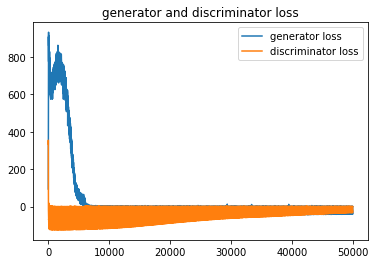

In [10]:
#training the GAN
import os
import pandas as pd
# from gan import GAN
import random
import tensorflow as tf

random.seed(42)
class TrainGan:

    def __init__(self, num_historical_days, batch_size=128):
        self.batch_size = batch_size
        self.data = []
#         files = [os.path.join('./stock_data', f) for f in os.listdir('./stock_data')]

        # Google Drive Method
        files = [f"{googlepath}stock_data/{f}" for f in os.listdir(f"{googlepath}stock_data")]
#         print(files)
      
        for file in files:
            print(file)
            #Read in file -- note that parse_dates will be need later
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df[['open','high','low','close','volume']]
            # #Create new index with missing days
            # idx = pd.date_range(df.index[-1], df.index[0])
            # #Reindex and fill the missing day with the value from the day before
            # df = df.reindex(idx, method='bfill').sort_index(ascending=False)
            #Normilize using a of size num_historical_days
            df = ((df -
            df.rolling(num_historical_days).mean().shift(-num_historical_days))
            /(df.rolling(num_historical_days).max().shift(-num_historical_days)
            -df.rolling(num_historical_days).min().shift(-num_historical_days)))
            #Drop the last 10 day that we don't have data for
            df = df.dropna()
            #Hold out the last year of trading for testing
            #Padding to keep labels from bleeding
            df = df[400:]
            #This may not create good samples if num_historical_days is a
            #mutliple of 7
            for i in range(num_historical_days, len(df), num_historical_days):
                self.data.append(df.values[i-num_historical_days:i])

        self.gan = GAN(num_features=5, num_historical_days=num_historical_days,
                        generator_input_size=200)

    def random_batch(self, batch_size=128):
        batch = []
        while True:
            batch.append(random.choice(self.data))
            if (len(batch) == batch_size):
                yield batch
                batch = []

    def train(self, print_steps=100, display_data=100, save_steps=SAVE_STEPS_AMOUNT):
        if not os.path.exists(f'{googlepath}models'):
            os.makedirs(f'{googlepath}models')
        sess = tf.Session()
        
        G_loss = 0
        D_loss = 0
        G_l2_loss = 0
        D_l2_loss = 0
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        currentStep = "0"
        
        g_loss_array = []
        d_loss_array = []
        
        if os.path.exists(f'{googlepath}models/checkpoint'):
                with open(f'{googlepath}models/checkpoint', 'rb') as f:
                    model_name = next(f).split('"'.encode())[1]
                filename = "{}models/{}".format(googlepath, model_name.decode())
                currentStep = filename.split("-")[1]
                new_saver = tf.train.import_meta_graph('{}.meta'.format(filename))
                new_saver.restore(sess, "{}".format(filename))

        for i, X in enumerate(self.random_batch(self.batch_size)):

            
            
            
            if i % 1 == 0:
                _, D_loss_curr, D_l2_loss_curr = sess.run([self.gan.D_solver, self.gan.D_loss, self.gan.D_l2_loss], feed_dict=
                        {self.gan.X:X, self.gan.Z:self.gan.sample_Z(self.batch_size, 200)})
                D_loss += D_loss_curr
                D_l2_loss += D_l2_loss_curr
            if i % 1 == 0:
                _, G_loss_curr, G_l2_loss_curr = sess.run([self.gan.G_solver, self.gan.G_loss, self.gan.G_l2_loss],
                        feed_dict={self.gan.Z:self.gan.sample_Z(self.batch_size, 200)})
                G_loss += G_loss_curr
                G_l2_loss += G_l2_loss_curr
                
            g_loss_array.append(G_loss_curr - G_l2_loss)
            d_loss_array.append(D_loss_curr - D_l2_loss)
            
            
            if (i+1) % print_steps == 0:
                print('Step={} D_loss={}, G_loss={}'.format(i + int(currentStep), D_loss/print_steps - D_l2_loss/print_steps, G_loss/print_steps - G_l2_loss/print_steps))
                #print('D_l2_loss = {} G_l2_loss={}'.format(D_l2_loss/print_steps, G_l2_loss/print_steps))
                G_loss = 0
                D_loss = 0
                G_l2_loss = 0
                D_l2_loss = 0
            if (i+1) % save_steps == 0:
                saver.save(sess, f'{googlepath}/models/gan.ckpt', i + int(currentStep))
            
            # end training at training_amount epochs
            if ((i + int(currentStep)) > TRAINING_AMOUNT):
                
                print("Reached {} epochs for GAN".format(i + int(currentStep)))
                sess.close()
                
                axisX = np.arange(0,len(g_loss_array),1)
                plt.plot(axisX, g_loss_array, label='generator loss')
                plt.plot(axisX, d_loss_array, label='discriminator loss')
                plt.legend()
                plt.title('generator and discriminator loss')
                plt.show()
                
                break

            # if (i+1) % display_data == 0:
            #     print('Generated Data')
            #     print(sess.run(self.gan.gen_data, feed_dict={self.gan.Z:self.gan.sample_Z(1, 200)}))
            #     print('Real Data')
            #     print(X[0])


# if __name__ == '__main__':
tf.reset_default_graph()
gan = TrainGan(HISTORICAL_DAYS_AMOUNT, 128)
gan.train()

Move trained model to deployed model

In [15]:
from shutil import copyfile


if not os.path.exists(f"{googlepath}deployed_models"):
	    os.makedirs(f"{googlepath}deployed_models")

copyfile(f"{googlepath}models/gan.ckpt-9999.data-00000-of-00001", f"{googlepath}deployed_models/gan.data-00000-of-00001") 
copyfile(f"{googlepath}models/gan.ckpt-9999.index", f"{googlepath}deployed_models/gan.index") 
copyfile(f"{googlepath}models/gan.ckpt-9999.meta", f"{googlepath}deployed_models/gan.meta ") 

'/content/drive/My Drive/Colab Notebooks/MarketGAN/deployed_models/gan.meta '

In [24]:
##Predict mode
#PREDICTING THE MODEL

import os
import pandas as pd
import random
import tensorflow as tf
import xgboost as xgb
from sklearn.externals import joblib
#/deployed_models/gan'
class Predict:
  def __init__(self, num_historical_days=20, days=10, pct_change=0, gan_model=f'{googlepath}/deployed_models/gan', xgb_model=f'xgb'):
    self.data = []
    self.num_historical_days = num_historical_days
    self.gan_model = gan_model
    self.xgb_model = xgb_model
       
    files = [f"{googlepath}stock_data/{f}" for f in os.listdir(f"{googlepath}stock_data")] 
    for file in files:
      
      print(file)
      df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
      df = df[['open','high','low','close','volume']]
            # data for new column labels that will use the pct_change of the closing data.
            # pct_change measure change between current and prior element. Map these into a 1x2
            # array to show if the pct_change > (our desired threshold) or less than.
            
      df = ((df -
            df.rolling(num_historical_days).mean().shift(-num_historical_days))
            /(df.rolling(num_historical_days).max().shift(-num_historical_days)
            -df.rolling(num_historical_days).min().shift(-num_historical_days)))
      df = df.dropna()
      self.data.append((file.split('/')[-1], df.iloc[0], df[200:200+num_historical_days].values))
      #split the df into arrays of length num_historical_days and append
      # to data, i.e. array of df[curr - num_days : curr] -> a batch of values
      # appending if price went up or down in curr day of "i" we are lookin
      # at
      
      
  def gan_predict(self):
    tf.reset_default_graph()
    gan = GAN(num_features=5, num_historical_days=self.num_historical_days, generator_input_size=200, is_train=False)
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      saver = tf.train.Saver()
      saver.restore(sess, self.gan_model)
      clf = joblib.load(self.xgb_model)
      for sym, date, data in self.data:
        features = sess.run(gan.features, feed_dict={gan.X:[data]})
        features = xgb.DMatrix(features)
        print('{} {} {}'.format(str(date).split(' ')[0], sym, clf.predict(features)[0][1] > 0.5))
        print(clf.predict(features))
        #predictions = np.array([x for x in gan_estimator.predict(p.gan_predict())])
        #print(predictions)

p = Predict()
p.gan_predict()


/content/drive/My Drive/Colab Notebooks/MarketGAN/stock_data/AAPL.csv
/content/drive/My Drive/Colab Notebooks/MarketGAN/stock_data/ATVI.csv
/content/drive/My Drive/Colab Notebooks/MarketGAN/stock_data/ADBE.csv
Tensor("Relu:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("Relu_1:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("Relu_2:0", shape=(?, 18, 1, 128), dtype=float32)
2304
Tensor("Relu_4:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("Relu_5:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("Relu_6:0", shape=(?, 18, 1, 128), dtype=float32)
2304
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/MarketGAN//deployed_models/gan
open AAPL.csv True
[[0.01988322 0.9801168 ]]
0.9801168
open ATVI.csv True
[[0.01865298 0.98134696]]
0.98134696
open ADBE.csv True
[[0.01855618 0.98144376]]
0.98144376


[[down, up]]

![alt text](https://raw.githubusercontent.com/nmharmon8/StockMarketGAN/master/figures/XGB_GAN_Confusion_Matrix_Up_Or_Down_Over_10_Days_normalize.png)


**Predictions of Up or Down movement over 10 Days The predictions over a 10 day period are quite good.**

Testing The data the was held out in the training phase is run through the Discriminator portion of the GAN and the activated weights of the last convolutional layer are extracted. The extracted features are then classified using XGBoost.

Results The confusion matrix shows the results of the model's classification. The perfect confusion matrix would only have predictions on the main diagonal. Each number off the main diagonal is a misclassification.

**The up and down are indicating the movement of the stock price. So if the stock is going up we predict that it is going up 87% of the time and if it is going down we predict it 93% of the time which is great!**